# Named Entity Recognition using Keras on Google AI Platform

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaschaHeyer/Machine-Learning-Training/blob/master/notebooks/named-entity-recognition/Named_Entity_Recognition_Bi_LSTM.ipynb)

## Overview

## Dataset

### Authenticate

Required to download the data and later deploy the model

In [0]:
try:
 from google.colab import auth
 auth.authenticate_user()
except:
 pass

### Autoreload

To auto-reload modules in jupyter notebook 
(so that changes in files *.py doesn't require manual reloading):

In [0]:
%load_ext autoreload
%autoreload 2

### Imports

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import unicodedata
 
  
import tensorflow as tf
  
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, Dropout, Bidirectional

import matplotlib.pyplot as plt

# Installing extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

Using TensorFlow backend.


     |████████████████████████████████| 757kB 4.1MB/s 


## Data
### Download data
Download from Google Cloud Storage

In [8]:
%%bash
gsutil cp gs://sascha-ml-engine/data/ner/ner.csv .

Copying gs://sascha-ml-engine/data/ner/ner.csv...
\ [1 files][149.8 MiB/149.8 MiB]                                                
Operation completed over 1 objects/149.8 MiB.                                    


## Read data

In [9]:
data = pd.read_csv("ner.csv", encoding="latin1", error_bad_lines=False)
data = data.fillna(method="ffill")
data.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


## Cleanup columns

In [10]:
data=data.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos", "shape"],axis=1)

data.head(10)

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O
5,1.0,through,O
6,1.0,London,B-geo
7,1.0,to,O
8,1.0,protest,O
9,1.0,the,O


## Build sentences

The training data consists of single words (one per row). We need them in a better format a complete sentence.

In [13]:
agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                    s["tag"].values.tolist())]
grouped = data.groupby("sentence_idx").apply(agg_func)
sentences = [s for s in grouped]
sentences_list = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences_list[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

## Analysis

### Maximum sentence length

In [14]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


### Length distribution

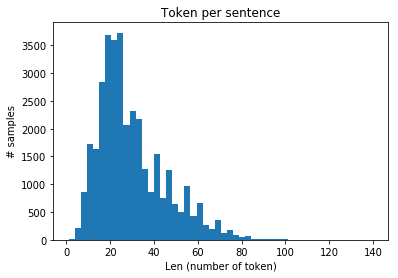

In [15]:
#plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

### Number of words

In [16]:
words = list(set(data["word"].values))
#words.append("ENDPAD")
n_words = len(words)
print ('Number of words:', n_words)

Number of words: 30168


### Number and type of tags

In [27]:
tags = list(set(data["tag"].values))
n_tags = len(tags)
print ('Number of tags:', n_tags)
print ('Type of tags:', tags)


Number of tags: 17
Type of tags: ['B-nat', 'B-per', 'O', 'B-gpe', 'I-org', 'B-org', 'B-tim', 'B-art', 'I-eve', 'I-nat', 'I-per', 'I-tim', 'B-eve', 'B-geo', 'I-geo', 'I-art', 'I-gpe']


## Preprocessing

### Text preprocessor used in training and prediction


* all texts has to be the same length to get feeded into our Bi-LSTM, this is done via sequence.pad_sequences(). Longer text is truncated and shorter text is padded.

In [28]:
%%writefile preprocess.py

from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  
  def __init__(self, max_sequence_length):
    self._max_sequence_length = max_sequence_length
    self._labels = None
    self.number_words = None
    self._tokenizer = None
    
  def fit(self, instances):
    tokenizer = text.Tokenizer(lower=False, filters=[], oov_token=None)
    tokenizer.fit_on_texts(instances)
    self._tokenizer = tokenizer
    self.number_words = len(tokenizer.word_index)
    print(self.number_words)
    
  def transform(self,instances):
    sequences = self._tokenizer.texts_to_sequences(instances)
    padded_sequences = pad_sequences(maxlen=140, sequences=sequences, padding="post",value=self.number_words - 1)
    return padded_sequences
    

Overwriting preprocess.py


In [29]:
from preprocess import TextPreprocessor

processor = TextPreprocessor(140)
processor.fit(sentences_list)
processor.labels = list(set(data["tag"].values))

X = processor.transform(sentences_list)

30168


### Save preprocessing state


In [0]:
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

### Tag preprocessing

In [0]:
tag2idx = {t: i for i, t in enumerate(tags)}

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

y

In [32]:
y[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

### Split training data
80/20 training / test

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train

array([[15948,    31, 13227, ..., 30167, 30167, 30167],
       [    9,  7021,   495, ..., 30167, 30167, 30167],
       [  205,   426,    42, ..., 30167, 30167, 30167],
       ...,
       [   33,  3472,    20, ..., 30167, 30167, 30167],
       [    9, 20937,   306, ..., 30167, 30167, 30167],
       [ 3917,     4,  5056, ..., 30167, 30167, 30167]], dtype=int32)

# Demo

## Model

### Create model

In [39]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 140, 140)          4223520   
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 140)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 140, 200)          192800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 140, 17)           3417      
Total params: 4,419,737
Trainable params: 4,419,737
Non-trainable params: 0
_________________________________________________________________


### Train model

In [40]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.1, verbose=1)

W0616 10:58:15.686563 139880807655296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25326 samples, validate on 2815 samples
Epoch 1/1
25326/25326 [==============================] - 444s 18ms/step - loss: 0.1217 - acc: 0.9762 - val_loss: 0.0402 - val_acc: 0.9889


### Save model

In [0]:
model.save('keras_saved_model.h5')

### Evaluate training

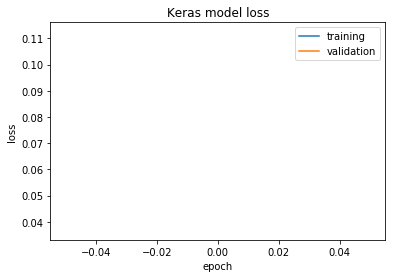

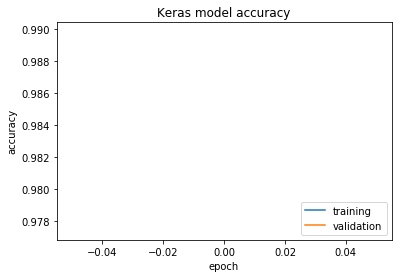

In [0]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

### Evaluate our model on test data

In [41]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, np.array(y_test), batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
7036/7036 [==============================] - 45s 6ms/step
test loss, test acc: [0.04017833407254569, 0.9889750677187922]


### Evaluate based on a classification report

In [42]:
#dict(tag2idx)
inv_tags = {v: k for k, v in tag2idx.items()}
inv_tags[1]


'B-per'

In [43]:

from sklearn_crfsuite.metrics import flat_classification_report

# Eval
pred_cat = model.predict(np.array(X_test))
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_test, -1)


# Convert the index to tag
pred_tag = [[inv_tags[i] for i in row] for row in pred]
y_te_true_tag = [[inv_tags[i] for i in row] for row in y_te_true] 


report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       101
       B-eve       0.00      0.00      0.00        67
       B-geo       0.70      0.89      0.78      7459
       B-gpe       0.94      0.85      0.90      3305
       B-nat       0.00      0.00      0.00        59
       B-org       0.76      0.41      0.53      4199
       B-per       0.84      0.65      0.73      3421
       B-tim       0.91      0.74      0.82      4042
       I-art       0.00      0.00      0.00        66
       I-eve       0.00      0.00      0.00        53
       I-geo       0.73      0.63      0.67      1473
       I-gpe       0.00      0.00      0.00        50
       I-nat       0.00      0.00      0.00        19
       I-org       0.70      0.62      0.66      3505
       I-per       0.77      0.80      0.78      3594
       I-tim       0.85      0.35      0.50      1216
           O       1.00      1.00      1.00    952411

    accuracy              

### Test model locally

In [0]:

reverse_word_map = dict(map(reversed, processor._tokenizer.word_index.items()))
#test = reverse_word_map.get(1)
#test


In [45]:
i = 22
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    
    print("{:14}: {}".format(reverse_word_map.get(w),tags[pred]))

Word           (True ): Pred
The           : O
State         : B-org
Department    : I-org
has           : O
not           : O
yet           : O
responded     : O
.             : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700          : O
3700     

##Google AI Platform

### Custom prediction route

In [50]:
%%writefile model_prediction.py

import os
import pickle
import numpy as np


class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor

  def postprocess(self, predictions):
    labeled_predictions = []
    
    for prediction in predictions:
      labeled_prediction = []
      for word_prediction in prediction:
        labeled_prediction.append(self._processor.labels[word_prediction])
      labeled_predictions.append(labeled_prediction)
    
    return labeled_predictions
    
  def predict(self, instances, **kwargs):
    transformed_instances = self._processor.transform(instances)
    predictions = self._model.predict(np.array(transformed_instances))
    predictions = np.argmax(predictions, axis=-1).tolist()

    labels = self.postprocess(predictions)
    return labels
    #return predictions


  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)

Overwriting model_prediction.py


### Test custom prediction route locally

In [51]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(['New York on Monday'])
print(results)

W0616 11:43:46.898596 139880807655296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 11:43:46.911922 139880807655296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 11:43:46.913149 139880807655296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops)

[['B-geo', 'I-geo', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


### Environment variables

In [0]:
import os

PROJECT='machine-learning-sascha' 
BUCKET='sascha-ml-engine'

ROOT='keras_named_entity_recognition'
MODEL_DIR=os.path.join(ROOT,'models')
PACKAGES_DIR=os.path.join(ROOT,'packages')

### GCP set project

In [0]:
!gcloud config set project {PROJECT}

### GCP cleanup bucket

In [0]:
# cleanup
!gsutil rm -r gs://{BUCKET}/{ROOT}

### Copy model and processor state to GCS bucket

In [0]:
!gsutil cp keras_saved_model.h5 gs://{BUCKET}/{MODEL_DIR}/
!gsutil cp processor_state.pkl gs://{BUCKET}/{MODEL_DIR}/

### Package files

In [0]:
%%writefile setup.py

from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'Keras==2.2.4'
]

setup(
  name="my_package",
  version="0.1",
  include_package_data=True,
  install_requires=REQUIRED_PACKAGES,
  packages=find_packages(),
  scripts=["preprocess.py", "model_prediction.py"]
)

In [0]:
!python setup.py sdist
!gsutil cp ./dist/my_package-0.1.tar.gz gs://{BUCKET}/{PACKAGES_DIR}/my_package-0.1.tar.gz

### Deploy model

In [0]:
MODEL_NAME='keras_ner'
VERSION_NAME='v1'
RUNTIME_VERSION='1.13'
REGION='us-central1'

In [0]:
!gcloud ai-platform models create {MODEL_NAME} --regions {REGION}

In [0]:
!gcloud ai-platform versions delete {VERSION_NAME} --model {MODEL_NAME} --quiet

In [0]:
!gcloud beta ai-platform versions create {VERSION_NAME} --model {MODEL_NAME} \
--origin=gs://{BUCKET}/{MODEL_DIR}/ \
--python-version=3.5 \
--runtime-version={RUNTIME_VERSION} \
--package-uris=gs://{BUCKET}/{PACKAGES_DIR}/my_package-0.1.tar.gz \
--prediction-class=model_prediction.CustomModelPrediction

### Online prediction
https://cloud.google.com/ml-engine/reference/rest/v1/projects/predict

https://cloud.google.com/ml-engine/docs/v1/predict-request

The instances[] object is required, and must contain the list of instances to get predictions for.

The structure of each element of the instances list is determined by your model's input definition. Instances can include named inputs (as objects) or can contain only unlabeled values.

Not all data includes named inputs. Some instances are simple JSON values (boolean, number, or string). However, instances are often lists of simple values, or complex nested lists.

In our case we send plain text where we want to get the predictions for {"instances": ["the quick brown fox", "la bruja le dio"]}

In [0]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

requests = ['Barack Obama arrived in London on Monday evening']
request_data = {'instances': requests}

print(request_data)

credentials = GoogleCredentials.get_application_default()
api = discovery.build(
  'ml', 'v1', credentials=credentials,
  discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

parent = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print(parent)
print("Model full name: {}".format(parent))
response = api.projects().predict(body=request_data, name=parent).execute()
print(response)


In [0]:
### Hyperparameter Results

### Hyperparameter Results


In [0]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
credentials = GoogleCredentials.get_application_default()

import json


PROJECT_ID='machine-learning-sascha'
JOB_NAME='ner_2019_06_11_16_13_47'

ml = discovery.build('ml', 'v1', credentials=credentials)
request = ml.projects().jobs().get(name='projects/{}/jobs/{}'.format(PROJECT_ID, JOB_NAME)).execute()


best_model = request['trainingOutput']['trials'][0]
print('Best Hyperparameters:')
print(json.dumps(best_model, indent=4))

